<a href="https://colab.research.google.com/github/nit-1418/Deep_learning/blob/main/Autoencoder_in_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.datasets import mnist
from keras.utils import plot_model
from keras import backend as K

In [ ]:
# load MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
# reshape to (28, 28, 1) and normalize input images
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [ ]:
# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 16

In [ ]:
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [32, 64]


In [ ]:
# build the autoencoder model
# first build the encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# stack of Conv2D(32)-Conv2D(64)
for filters in layer_filters:
  x = Conv2D(filters = filters,
                kernel_size = kernel_size,
                activation = 'relu',
                strides = 2,
                padding = 'same') (x)


In [ ]:
# shape info needed to build decoder model
# so we don't do hand computation
# the input to the  decoder's first
# Conv2DTranspose will have this shape
# shape is (7, 7, 64) which is processed by
# the decoder back to (28, 28, 1)
shape = K.int_shape(x)

In [ ]:
# generate latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name = 'latent_vector')(x)

In [ ]:
# instantiate encoder model
encoder = Model(inputs,
                latent,name ='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        320       
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 latent_vector (Dense)       (None, 16)                50192     
                                                                 
Total params: 69008 (269.56 KB)
Trainable params: 69008 (269.56 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


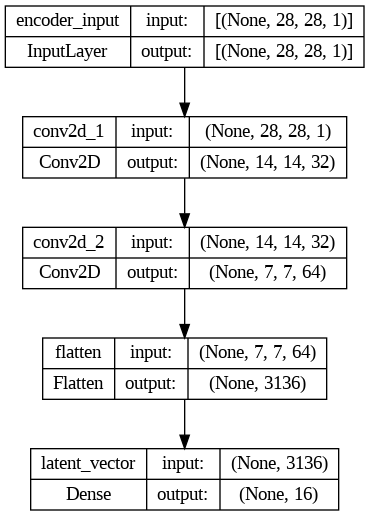

In [ ]:
plot_model(encoder,
           to_file = 'encoder.png',
           show_shapes = True)

In [ ]:
# build the decoder model
latent_inputs = Input(shape = (latent_dim,), name = 'decoder_input')
# use the shape (7, 7, 64) that was earlier saved
x = Dense(shape[1] * shape[2] * shape[3]) (latent_inputs)
# from vector to suitable shape for transposed conv
x = Reshape((shape[1], shape[2], shape[3]))(x)


In [ ]:
# stack of Conv2DTranspose(64)-Conv2Dtranspose (32)
for fillters in layer_filters[::-1]:
  x = Conv2DTranspose(filters = filters,
                      kernel_size = kernel_size,
                      activation = 'relu',
                      strides=2,
                      padding = 'same')(x)

In [ ]:
# reconstruct the input
outputs = Conv2DTranspose(filters = 1,
                          kernel_size = kernel_size,
                          activation = 'sigmoid',
                          padding = 'same',
                          name = 'decoder_output')(x)

In [ ]:
# instantiate decoder model
decoder = Model(latent_inputs, outputs, name = 'decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 16)]              0         
                                                                 
 dense (Dense)               (None, 3136)              53312     
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 64)        36928     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 64)        36928     
 Transpose)                                                      
                                                                 
 decoder_output (Conv2DTran  (None, 28, 28, 1)         577 

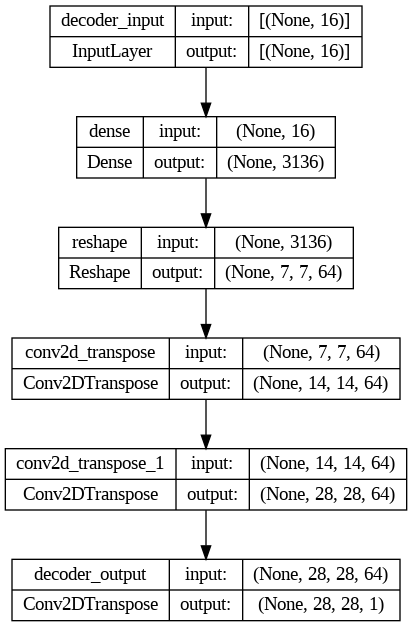

In [ ]:
plot_model(decoder, to_file='decoder.png', show_shapes=True)

In [ ]:
# autoencoder = encoder + decoder
# instantiate autoencoder model
autoencoder = Model(inputs,
                    decoder(encoder(inputs)),
                    name = 'autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 16)                69008     
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         127745    
                                                                 
Total params: 196753 (768.57 KB)
Trainable params: 196753 (768.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


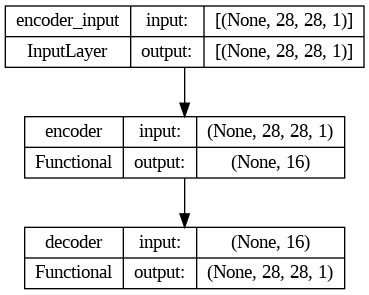

In [ ]:
plot_model(autoencoder,
           to_file = 'autoencoder.png',
           show_shapes=True)

In [ ]:
# Mean Square Error (MSE) loss function , Adam optimizer
autoencoder.compile(loss = 'mse', optimizer='adam')

In [ ]:
# train the autoencoder
autoencoder.fit(x_train,
                x_train,
                validation_data = (x_test, x_test),
                epochs = 1,
                batch_size = batch_size)

1875/1875 [==============================] - 158s 83ms/step - loss: 0.0019 - val_loss: 0.1140


In [ ]:
# predict the autoencoder output from test data
x_decoded = autoencoder.predict(x_test)

313/313 [==============================] - 9s 30ms/step


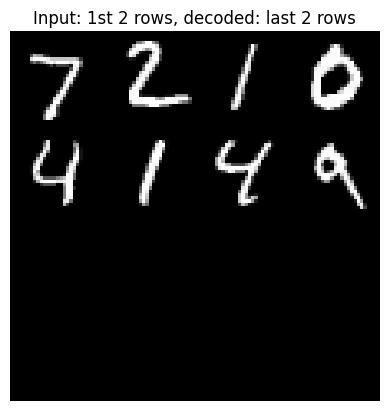

In [ ]:
# display the 1st 8 test input and decoded images
imgs = np.concatenate([x_test[:8], x_decoded[:8]])
imgs = imgs.reshape((4, 4, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Input: 1st 2 rows, decoded: last 2 rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig('input_and_decoded.png')
plt.show()